In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.0 MB/s 


In [5]:
pip uninstall opencv-python opencv-contrib-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-contrib-python-4.1.2.30


In [6]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 242 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical




Segmentation Models: using `keras` framework.


In [3]:
#Resizing images, if needed
SIZE_X = 700
SIZE_Y = 400 
n_classes = 2 #Number of classes for segmentation

#Capture training image info as a list
train_images = []

imagePath = r'/Users/stefanofochesatto/Desktop/Keras Network Test/dataset/train/images'
maskPath = r'/Users/stefanofochesatto/Desktop/Keras Network Test/dataset/train/masks'

for directory_path in sorted(glob.glob(imagePath)):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in sorted(glob.glob(maskPath)):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        mask = cv2.imread(mask_path, 0)
        mask = np.where(mask > 0, 1, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = 6)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)




In [4]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

/Users/stefanofochesatto/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1]
Class values in the dataset are ...  [0 1]


In [ ]:

######################################################
#Reused parameters in all models

n_classes=2
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.50, 0.50])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


########################################################################
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())

history1=model1.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))


model1.save('res34_backbone_50epochs.hdf5')

In [5]:
BACKBONE1 = 'resnet50'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [6]:
####################################################

from keras.models import load_model


### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model1 = load_model('/Users/stefanofochesatto/Desktop/Keras Network Test/saved_models/linkNet_arch_res50_backbone_50epochs.hdf5', compile=False)


#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)

#Vaerify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')
##############################################################

#Test some random images
# import random
# test_img_number = random.randint(0, len(X_test2))
# test_img = X_test2[test_img_number]
# ground_truth=y_test[test_img_number]
# test_img_input=np.expand_dims(test_img, 0)

# test_img_input1 = preprocess_input2(test_img_input)

# test_pred1 = model2.predict(test_img_input1)
# test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


# plt.figure(figsize=(12, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(test_prediction1, cmap='gray')
# plt.show()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-06-24 17:15:10.089614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-24 17:15:10.089850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-24 17:15:11.321812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/stefanofochesatto/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/stefanofochesatto/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/stefanofochesatto/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/stefanofochesatto/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/stefanofochesatto/miniforge3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "decoder_stage0_add" (type Add).
    
    Dimensions must be equal, but are 26 and 25 for '{{node model_1/decoder_stage0_add/add}} = AddV2[T=DT_FLOAT](model_1/decoder_stage0c_relu/Relu, model_1/stage4_unit1_relu1/Relu)' with input shapes: [?,44,26,1024], [?,44,25,1024].
    
    Call arguments received by layer "decoder_stage0_add" (type Add):
      • inputs=['tf.Tensor(shape=(None, 44, 26, 1024), dtype=float32)', 'tf.Tensor(shape=(None, 44, 25, 1024), dtype=float32)']


1/1 [==============================] - 0s 149ms/step


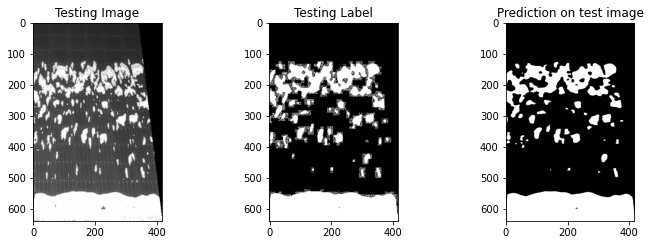

In [ ]:
##############################################################

#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))

test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)
test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()